# Problem Statement:

Forecast the Airlines Passengers data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

In [1]:
# importing basic libraries

import numpy as np
import pandas as pd
import seaborn as sns
from numpy import log
from numpy import sqrt
from pandas import read_csv
from pandas import DataFrame
import statsmodels.api as smfa
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
# loading data
df = pd.read_excel('Airlines+Data.xlsx')

# Data Exploration

In [3]:
df.shape

(96, 2)

In [4]:
df.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [5]:
df.tail()

,Month,Passengers
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271
95,2002-12-01,306


In [6]:
df.sample(5)

,Month,Passengers
36,1998-01-01,171
38,1998-03-01,193
47,1998-12-01,194
9,1995-10-01,119
5,1995-06-01,135


## Quick Data Check

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


## Statistical summary

In [8]:
df.describe()

,Month,Passengers
count,96,96.000000
mean,1998-12-16 05:00:00,213.708333
min,1995-01-01 00:00:00,104.000000
25%,1996-12-24 06:00:00,156.000000
50%,1998-12-16 12:00:00,200.000000
75%,2000-12-08 18:00:00,264.750000
max,2002-12-01 00:00:00,413.000000
std,NaN,71.918216


# Data Preprocessing

## Identifying Duplicates

In [9]:
df.duplicated().sum()

0

- There is no duplicate values present in dataset.

## Identifying Missing Values

In [10]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

- There is no missing values in dataset.

## Data Type Conversion

In [11]:
df = pd.read_excel("Airlines+Data.xlsx", header=0, index_col=0, parse_dates=True)

In [28]:
df.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


# Data Visualization

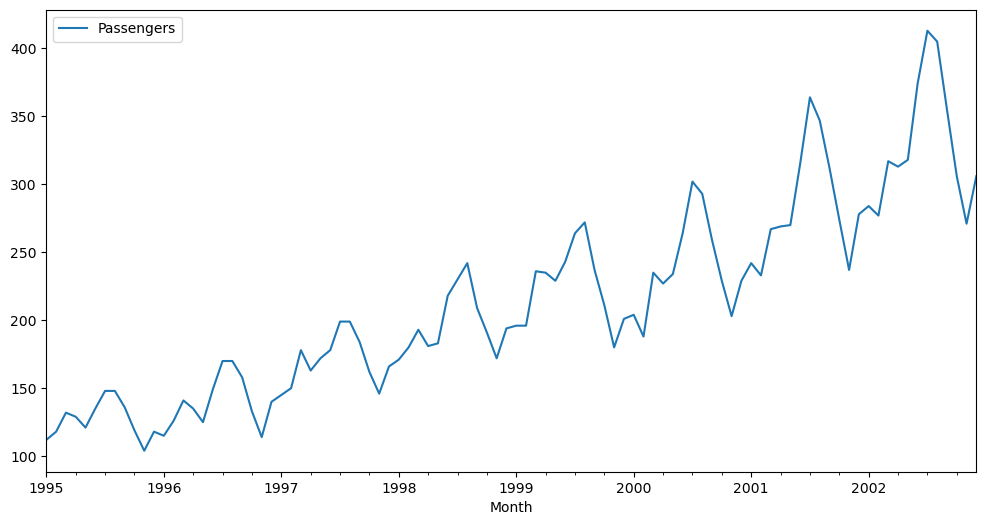

In [29]:
df.plot(figsize=(12,6));

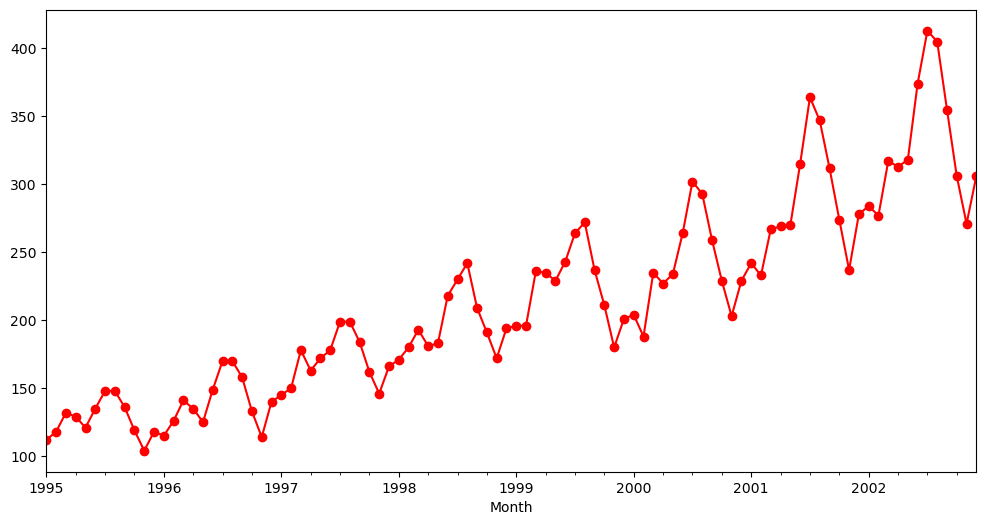

In [30]:
df['Passengers'].plot(figsize=(12, 6),color='red',marker='o');

- There is a clear upward trajectory in the line plot, suggesting a positive trend.

## Histogram and Density Plots

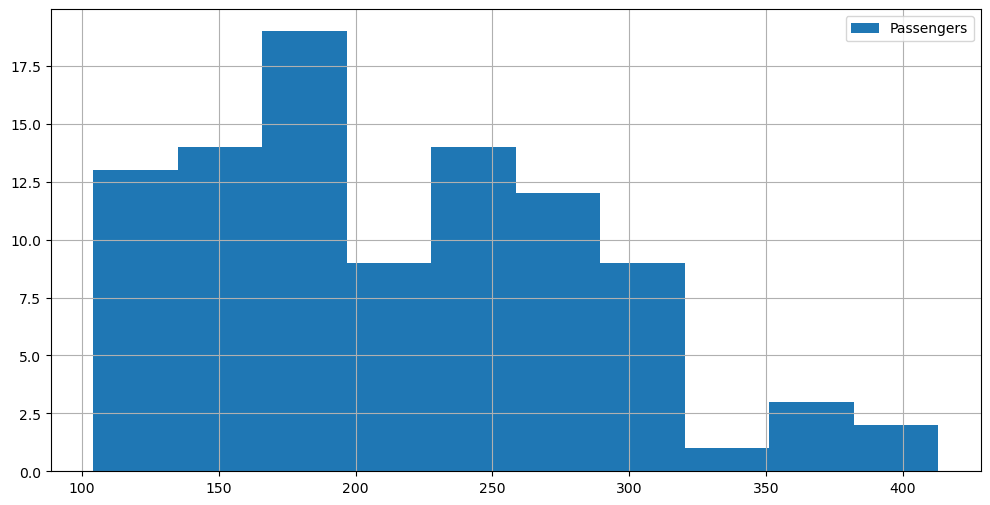

In [31]:
df.Passengers.hist(figsize=(12,6),legend=True);

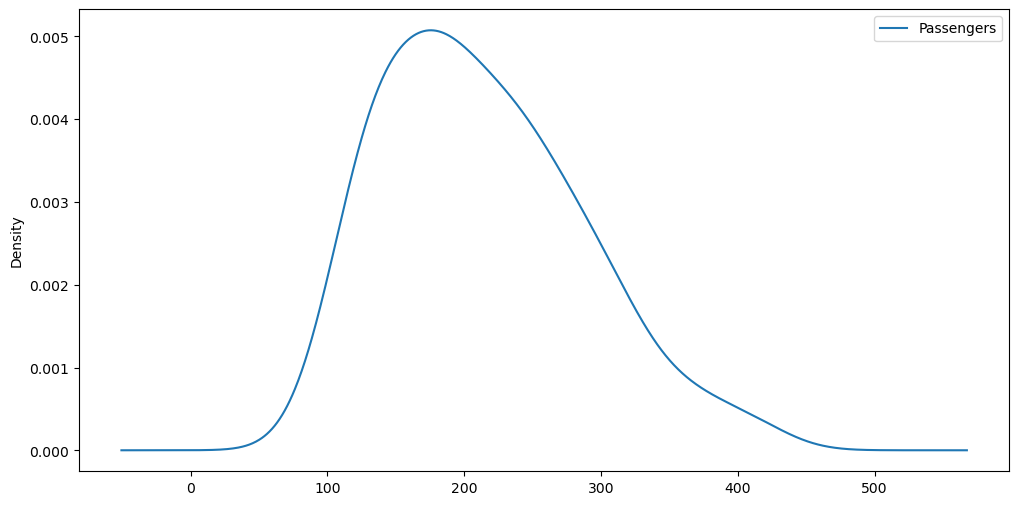

In [32]:
df.Passengers.plot(kind='kde',figsize=(12,6),legend=True);

- The distribution of the number of passengers is skewed to the right.

## Lag plot

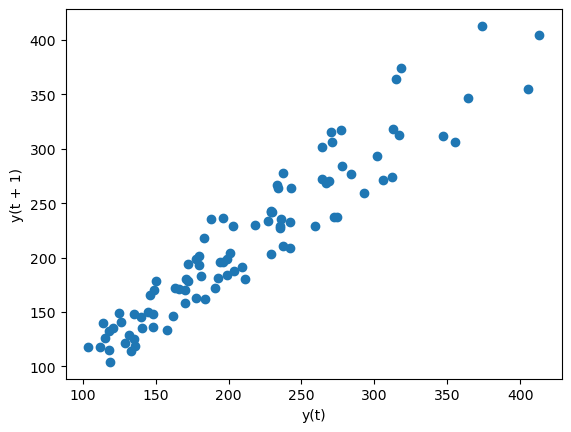

In [33]:
from pandas.plotting import lag_plot

lag_plot(df);

- The above lagplot suggests autocorrelation is present. A positive linear trend (i.e. going upwards from left to right) is suggestive of positive autocorrelation

## ETS - Decomposition

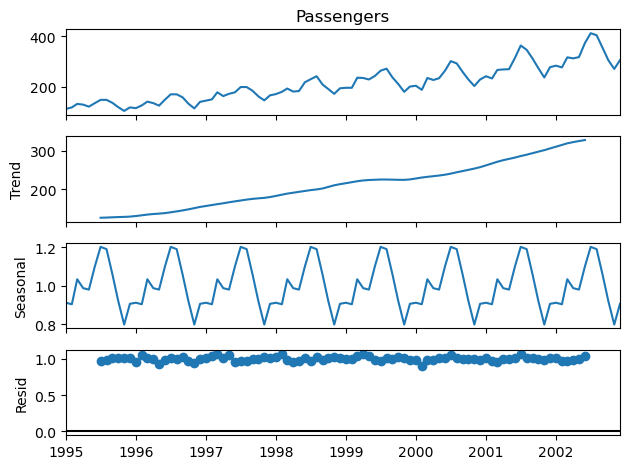

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Passengers'], model='multiplicative')  # model='mul' also works
result.plot();

- Based on this chart, it looks like the trend in the - earlier days is increasing at a higher rate than just linear 

## Simple Moving Average

In [35]:
df['6-month-SMA'] = df['Passengers'].rolling(window=6).mean()
df['12-month-SMA'] = df['Passengers'].rolling(window=12).mean()

In [36]:
df.head(15)

,Passengers,6-month-SMA,12-month-SMA
Month,,,
1995-01-01,112,NaN,NaN
1995-02-01,118,NaN,NaN
1995-03-01,132,NaN,NaN
1995-04-01,129,NaN,NaN
1995-05-01,121,NaN,NaN
1995-06-01,135,124.500000,NaN
1995-07-01,148,130.500000,NaN
1995-08-01,148,135.500000,NaN
1995-09-01,136,136.166667,NaN


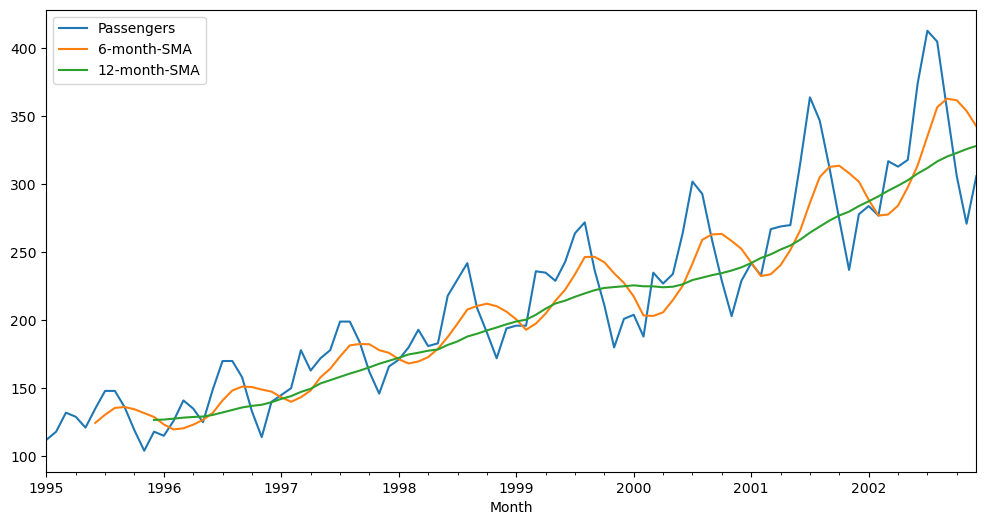

In [37]:
df.plot(figsize=(12,6), legend=True);

We just calculated the SMA based on some window. However, basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an EWMA (Exponentially weighted moving average).

## Exponentially Weighted Moving Average

In [38]:
df['EWMA12'] = df['Passengers'].ewm(span=12,adjust=False).mean()

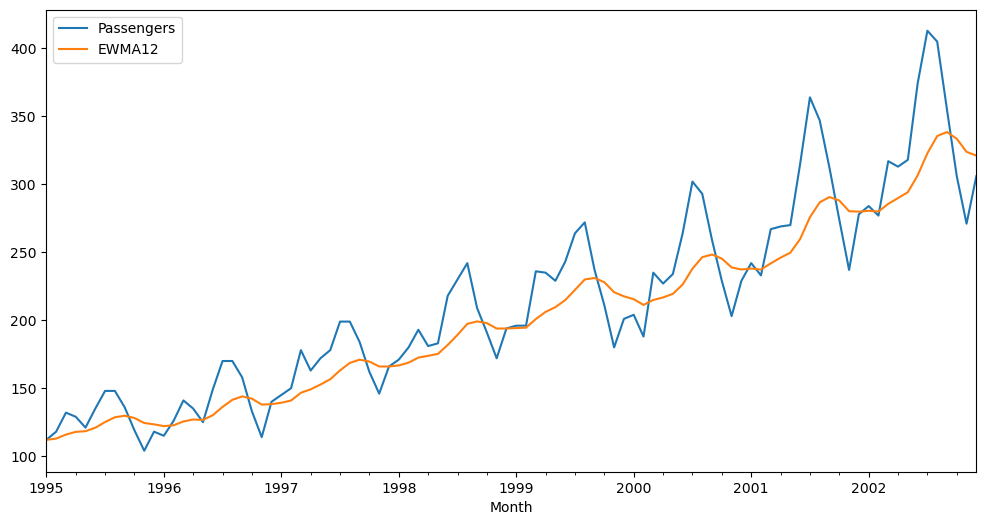

In [39]:
df[['Passengers','EWMA12']].plot(figsize=(12,6), legend=True);

## Comparing SMA to EWMA

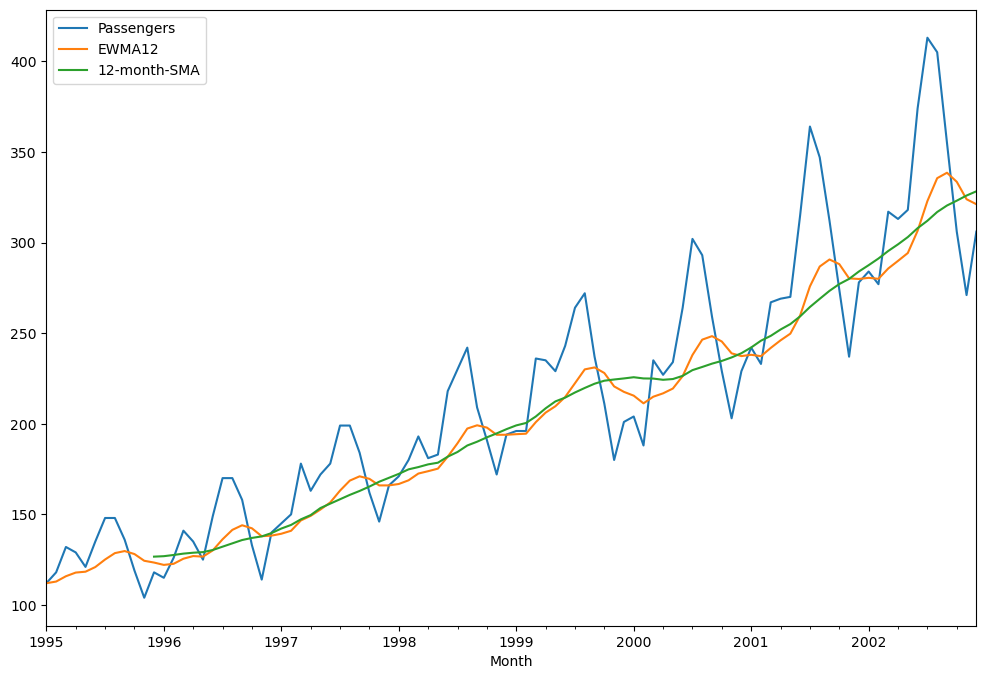

In [40]:
df[['Passengers','EWMA12','12-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

- The above example employed Simple Exponential Smoothing with one smoothing factor α. Unfortunately, this technique does a poor job of forecasting when there is a trend in the data as seen above.
- In the next section we'll look at Double and Triple Exponential Smoothing with the Holt-Winters Methods.

## Double Exponential Smoothing

In Double Exponential Smoothing (aka Holt's Method) we introduce a new smoothing factor 
 (beta) that addresses trend:

In [41]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['DESadd12'] = ExponentialSmoothing(df['Passengers'], trend='add').fit().fittedvalues.shift(-1)
df.head()

C:\Users\vijay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Passengers,6-month-SMA,12-month-SMA,EWMA12,DESadd12
Month,,,,,
1995-01-01,112,NaN,NaN,112.000000,114.111734
1995-02-01,118,NaN,NaN,112.923077,120.107640
1995-03-01,132,NaN,NaN,115.857988,134.084785
1995-04-01,129,NaN,NaN,117.879836,131.134853
1995-05-01,121,NaN,NaN,118.359861,123.149065


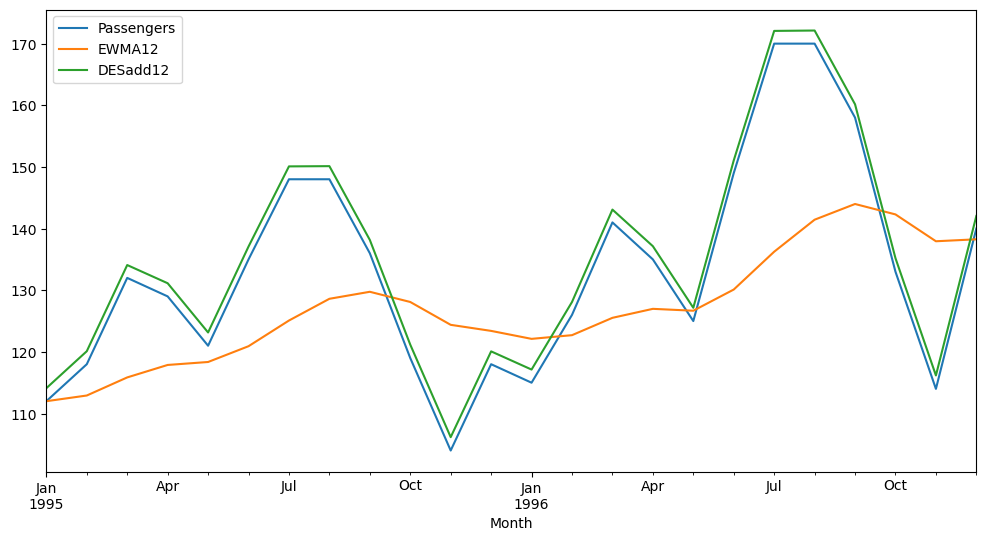

In [42]:
df[['Passengers','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

- Here we can see that Double Exponential Smoothing is a much better representation of the time series data.
- Let's see if using a multiplicative seasonal adjustment helps.

In [43]:
df['DESmul12'] = ExponentialSmoothing(df['Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

C:\Users\vijay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Passengers,6-month-SMA,12-month-SMA,EWMA12,DESadd12,DESmul12
Month,,,,,,
1995-01-01,112,NaN,NaN,112.000000,114.111734,111.999903
1995-02-01,118,NaN,NaN,112.923077,120.107640,118.025989
1995-03-01,132,NaN,NaN,115.857988,134.084785,132.042498
1995-04-01,129,NaN,NaN,117.879836,131.134853,129.145049
1995-05-01,121,NaN,NaN,118.359861,123.149065,121.141543


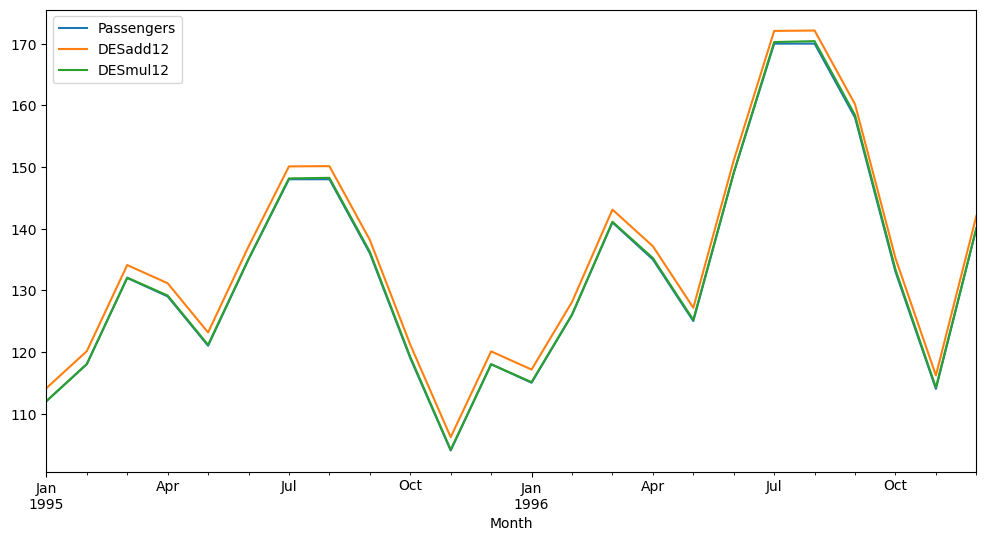

In [44]:
df[['Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

- Although minor, it does appear that a multiplicative adjustment gives better results. 
- Note that the green line almost completely overlaps the original data.

## Triple Exponential Smoothing

With Triple Exponential Smoothing (aka the Holt-Winters Method) we introduce a smoothing factor 
 (gamma) that addresses seasonality:

In [45]:
df['TESadd12'] = ExponentialSmoothing(df['Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

C:\Users\vijay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Passengers,6-month-SMA,12-month-SMA,EWMA12,DESadd12,DESmul12,TESadd12
Month,,,,,,,
1995-01-01,112,NaN,NaN,112.000000,114.111734,111.999903,111.999957
1995-02-01,118,NaN,NaN,112.923077,120.107640,118.025989,119.930394
1995-03-01,132,NaN,NaN,115.857988,134.084785,132.042498,134.245270
1995-04-01,129,NaN,NaN,117.879836,131.134853,129.145049,130.733385
1995-05-01,121,NaN,NaN,118.359861,123.149065,121.141543,123.859669


In [46]:
df['TESmul12'] = ExponentialSmoothing(df['Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

C:\Users\vijay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vijay\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


,Passengers,6-month-SMA,12-month-SMA,EWMA12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,,
1995-01-01,112,NaN,NaN,112.000000,114.111734,111.999903,111.999957,113.645508
1995-02-01,118,NaN,NaN,112.923077,120.107640,118.025989,119.930394,111.327302
1995-03-01,132,NaN,NaN,115.857988,134.084785,132.042498,134.245270,134.355930
1995-04-01,129,NaN,NaN,117.879836,131.134853,129.145049,130.733385,129.668662
1995-05-01,121,NaN,NaN,118.359861,123.149065,121.141543,123.859669,129.739643


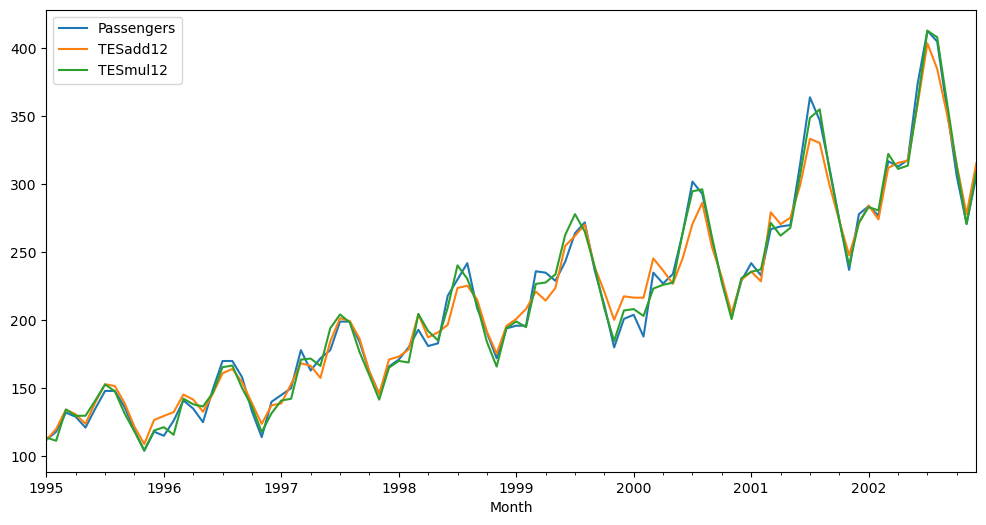

In [47]:
df[['Passengers','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

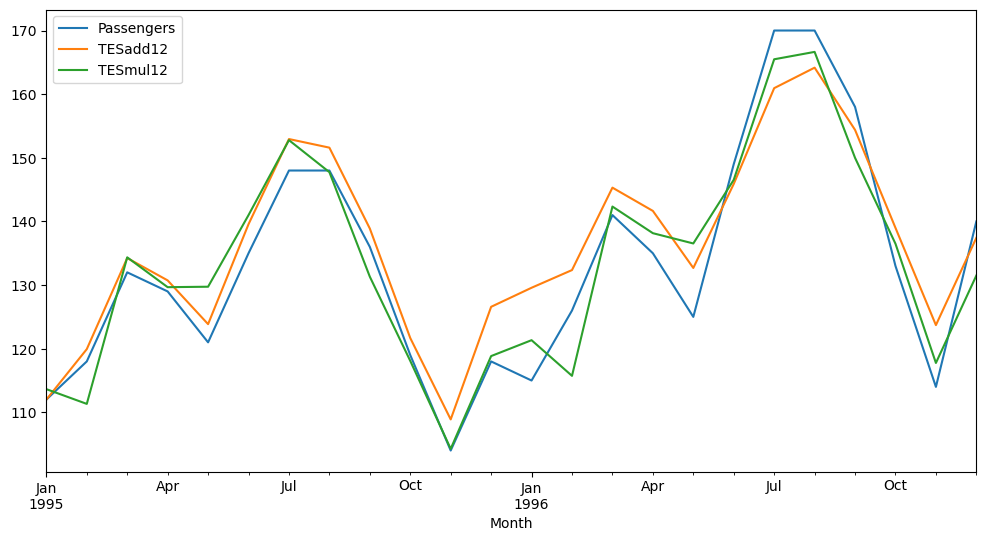

In [48]:
df[['Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

# ACF PLot

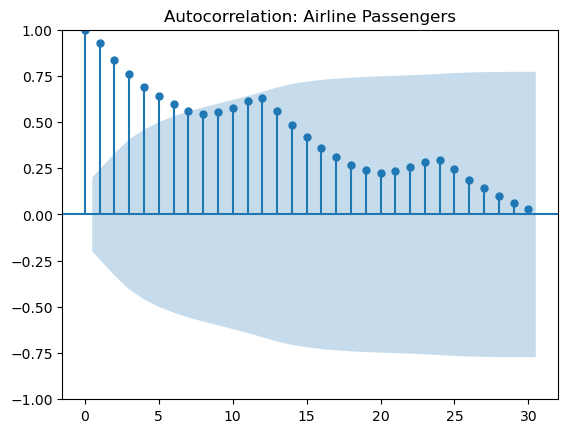

In [49]:
plot_acf(df['Passengers'],title = 'Autocorrelation: Airline Passengers', lags=30);

- This plot indicates non-stationary data, as there are a large number of lags before ACF values drop off.

## PACF Plots

- Partial autocorrelations work best with stationary data.
- To make the Airline Passengers data stationary, we'll first apply differencing

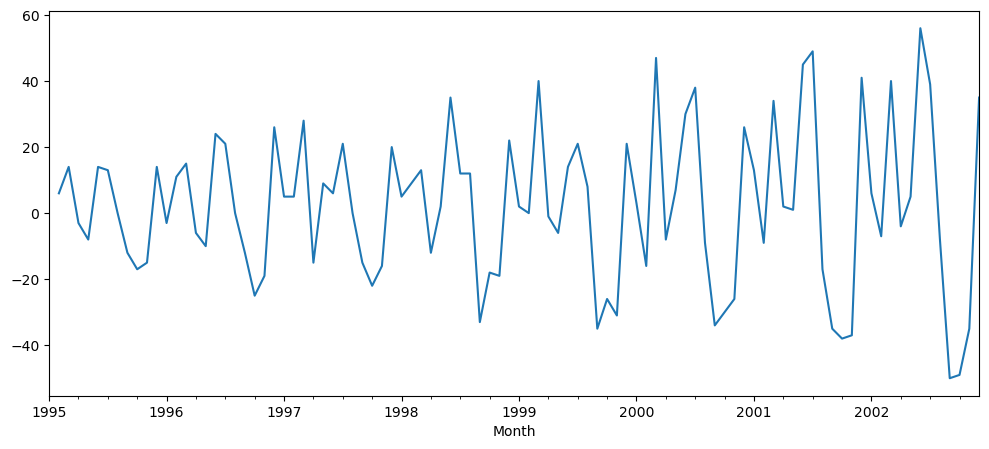

In [50]:
from statsmodels.tsa.statespace.tools import diff

df['d1'] = diff(df['Passengers'],k_diff=1)
df['d1'].plot(figsize=(12,5));

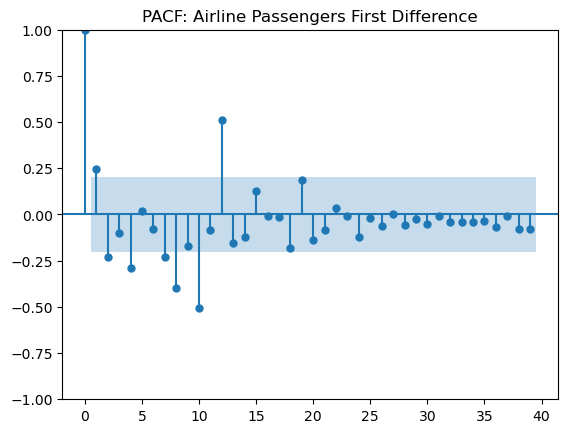

In [52]:
lags=40
plot_pacf(df['d1'].dropna(),title='PACF: Airline Passengers First Difference', lags=np.arange(lags));

- This tells us that the AR component should be more important than MA.

# Tests for Stationarity

## Augmented Dickey-Fuller Test

In [54]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [56]:
adf_test(df['Passengers'])

Augmented Dickey-Fuller Test: 
ADF test statistic       1.340248
p-value                  0.996825
# lags used             12.000000
# observations          83.000000
critical value (1%)     -3.511712
critical value (5%)     -2.897048
critical value (10%)    -2.585713
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [59]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

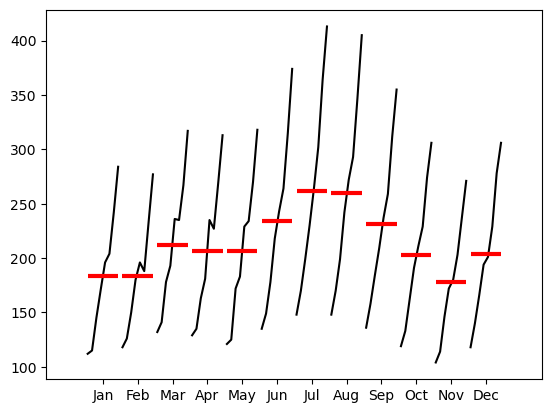

In [60]:
month_plot(df['Passengers']);

In [61]:
dfq = df['Passengers'].resample(rule='Q').mean()

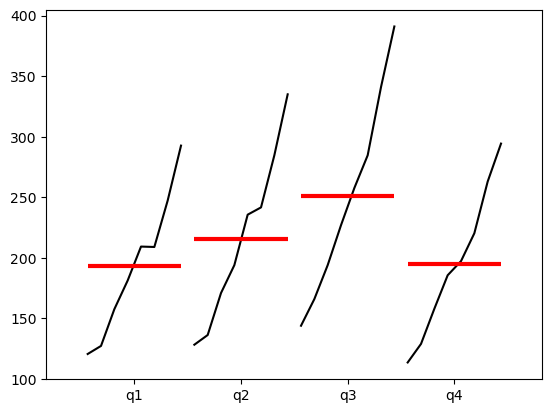

In [62]:
quarter_plot(dfq);

In [64]:
from pmdarima import auto_arima

In [65]:
stepwise_fit = auto_arima(df['Passengers'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=618.049, Time=0.56 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=622.012, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=615.965, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=616.628, Time=0.28 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=618.192, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=617.814, Time=0.49 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=617.881, Time=0.41 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=616.531, Time=0.24 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=618.221, Time=0.11 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=617.862, Time=0.23 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=617.462, Time=0.25 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=616.076, Time=0.18 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=619.394, Time=0.76 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -304.983
Date:                            Thu, 22 Feb 2024   AIC                            615.965
Time:                                    18:21:53   BIC                            623.222
Sample:                                01-01-1995   HQIC                           618.881
                                     - 12-01-2002                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2250      0.099     -2.276      0.023      -0.419      -0.031
ar.S.L12      -0.2274      0.089     -2.548      0.011      -0.402      -0.052
sigma2        90.2700     14.667      6.155      0.000      61.524     119.016
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.23
Prob(Q):                              0.97   Prob(JB):                         0.33
Heteroskedasticity (H):               1.77   Skew:                             0.39
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Data Splitting

In [78]:
df1 = df[['Passengers']]

In [79]:
len(df1)

96

In [81]:
# Set one year for testing
train = df1.iloc[:84]
test = df1.iloc[84:]

In [82]:
print("Shape of train: ",train.shape)
print("Shape of test: ", test.shape)

Shape of train:  (84, 1)
Shape of test:  (12, 1)


# Model Selection

In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [85]:
model = SARIMAX(train['Passengers'],order=(1,1,0),seasonal_order=(1, 1, 0, 12))
results = model.fit()
results.summary()

C:\Users\vijay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vijay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                   84
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -262.555
Date:                            Thu, 22 Feb 2024   AIC                            531.110
Time:                                    18:39:01   BIC                            537.898
Sample:                                01-01-1995   HQIC                           533.810
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2377      0.108     -2.204      0.028      -0.449      -0.026
ar.S.L12      -0.2595      0.097     -2.685      0.007      -0.449      -0.070
sigma2        94.2022     16.779      5.614      0.000      61.315     127.089
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.31
Prob(Q):                              0.98   Prob(JB):                         0.32
Heteroskedasticity (H):               2.60   Skew:                             0.41
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1

predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,0)(1,1,0,12) Predictions')

C:\Users\vijay\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [88]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Passengers'][i]}")

predicted=284.5306336, expected=284
predicted=274.635315 , expected=277
predicted=311.7896881, expected=317
predicted=311.2468612, expected=313
predicted=313.7914165, expected=318
predicted=354.90203  , expected=374
predicted=401.0469561, expected=413
predicted=386.1230311, expected=405
predicted=351.3824801, expected=355
predicted=315.4583982, expected=306
predicted=281.3127704, expected=271
predicted=318.4204421, expected=306


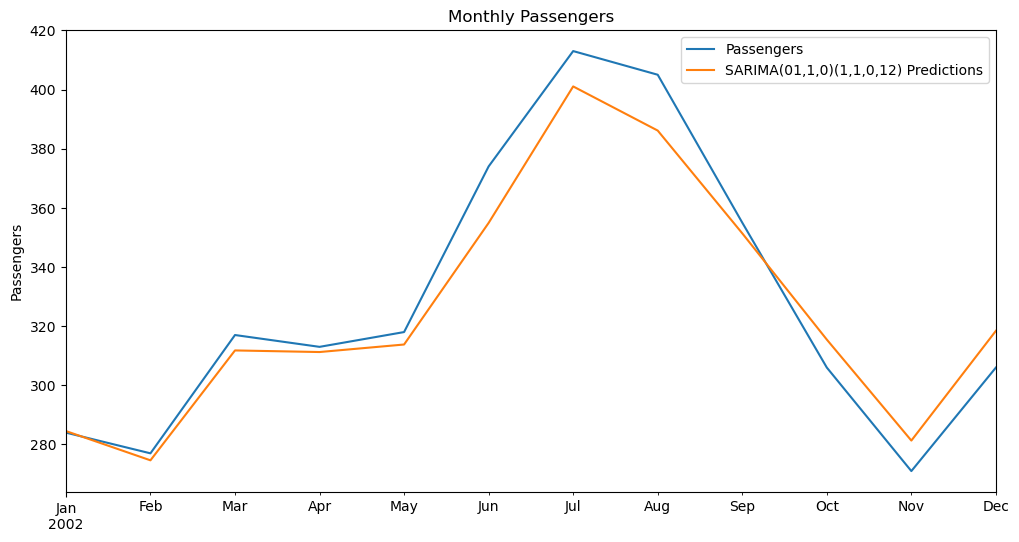

In [93]:
# Plot predictions against known values
title = 'Monthly Passengers'
ylabel='Passengers'
xlabel=''

ax = test['Passengers'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Model Evaluation

In [90]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Passengers'], predictions)
print(f'SARIMA(1,1,0)(1,1,0,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 106.7435301


In [91]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Passengers'], predictions)
print(f'SARIMA(1,1,0)(1,1,0,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 10.33167606


## Retrain the model on the full data, and forecast the future

In [95]:
model = SARIMAX(df1['Passengers'],order=(1,1,0),seasonal_order=(1,1,0,12))

results = model.fit()

fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(1,1,0)(1,1,0,12) Forecast')

C:\Users\vijay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vijay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vijay\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


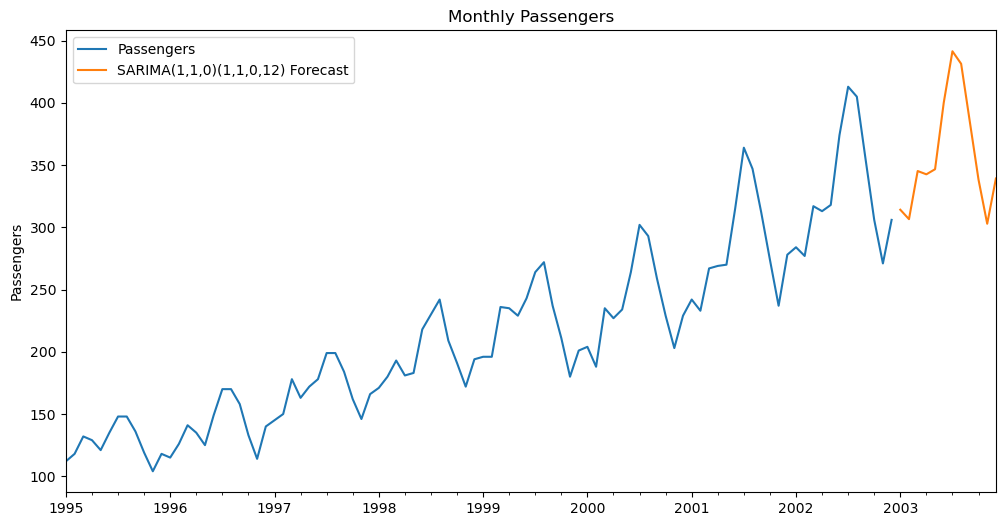

In [96]:
# Plot predictions against known values
title = 'Monthly Passengers'
ylabel='Passengers'
xlabel=''

ax = df1['Passengers'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

- With Auto_Arima we get values for SARIMAX as SARIMAX(1, 1, 0)x(1, 1, 0, 12).

# Forecasting Using Facebook Prophet

In [125]:
from prophet import Prophet

In [126]:
df = pd.read_excel('Airlines+Data.xlsx')

In [127]:
df.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

### Format the Data

In [128]:
df.columns = ['ds','y']

In [129]:
df['ds'] = pd.to_datetime(df['ds'])

<Axes: xlabel='ds'>

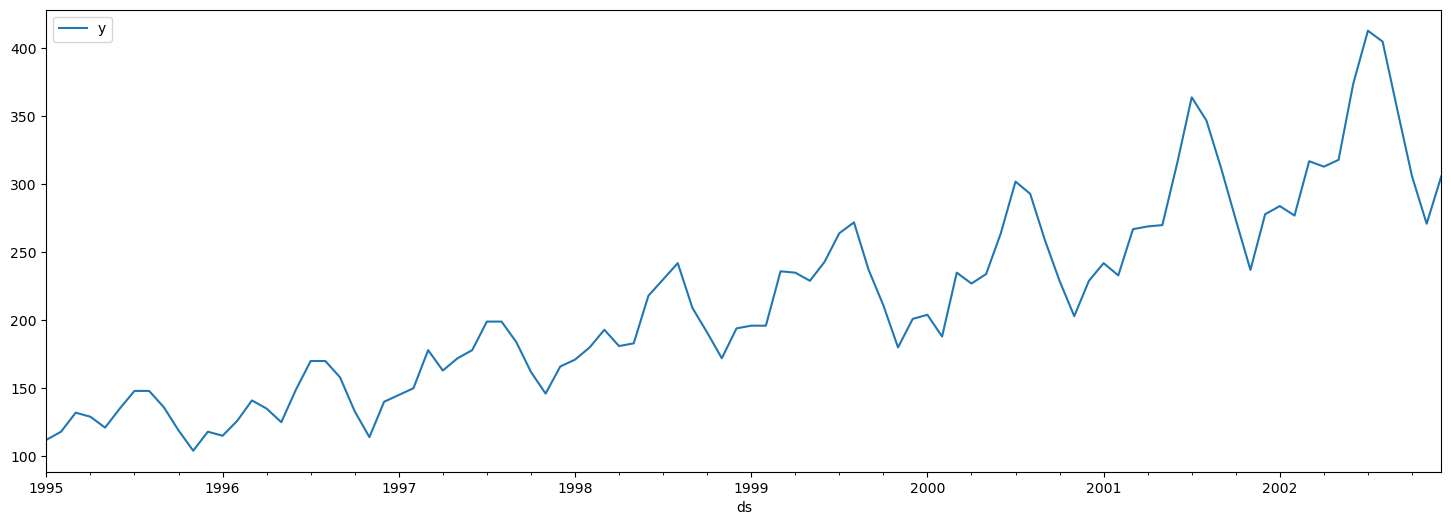

In [130]:
df.plot(x='ds',y='y',figsize=(18,6))

In [131]:
train = df.iloc[:84]
test = df.iloc[84:]

### Create and Fit Model

In [132]:
m = Prophet()
m.fit(train)

19:18:37 - cmdstanpy - INFO - Chain [1] start processing
19:18:38 - cmdstanpy - INFO - Chain [1] done processing


### Create "future" placeholder dataframe

In [133]:
future = m.make_future_dataframe(periods=12,freq = 'MS')

### Predict and fill in the Future

In [134]:
forecast = m.predict(future)

In [135]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1995-01-01,111.576192,82.651228,110.685760,111.576192,111.576192,-15.174502,-15.174502,-15.174502,-15.174502,-15.174502,-15.174502,0.0,0.0,0.0,96.401690
1,1995-02-01,113.384696,82.783031,109.825412,113.384696,113.384696,-17.205152,-17.205152,-17.205152,-17.205152,-17.205152,-17.205152,0.0,0.0,0.0,96.179545
2,1995-03-01,115.018184,113.619298,141.769546,115.018184,115.018184,13.422903,13.422903,13.422903,13.422903,13.422903,13.422903,0.0,0.0,0.0,128.441087
3,1995-04-01,116.826689,109.549313,137.997108,116.826689,116.826689,7.562647,7.562647,7.562647,7.562647,7.562647,7.562647,0.0,0.0,0.0,124.389336
4,1995-05-01,118.576854,107.324262,134.172967,118.576854,118.576854,2.109331,2.109331,2.109331,2.109331,2.109331,2.109331,0.0,0.0,0.0,120.686185


In [136]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
91,2002-08-01,314.497302,340.487423,369.153204,314.075531,314.878883,40.177925,40.177925,40.177925,40.177925,40.177925,40.177925,0.0,0.0,0.0,354.675227
92,2002-09-01,317.254617,315.166412,344.958559,316.757961,317.726582,12.856289,12.856289,12.856289,12.856289,12.856289,12.856289,0.0,0.0,0.0,330.110906
93,2002-10-01,319.922986,294.590504,320.781021,319.341703,320.469832,-12.655979,-12.655979,-12.655979,-12.655979,-12.655979,-12.655979,0.0,0.0,0.0,307.267007
94,2002-11-01,322.680301,271.107951,299.102465,322.016613,323.319460,-37.898512,-37.898512,-37.898512,-37.898512,-37.898512,-37.898512,0.0,0.0,0.0,284.781789
95,2002-12-01,325.348670,292.544614,320.997601,324.566758,326.088606,-17.900658,-17.900658,-17.900658,-17.900658,-17.900658,-17.900658,0.0,0.0,0.0,307.448012


In [137]:
test.tail()

,ds,y
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271
95,2002-12-01,306


<Axes: xlabel='ds'>

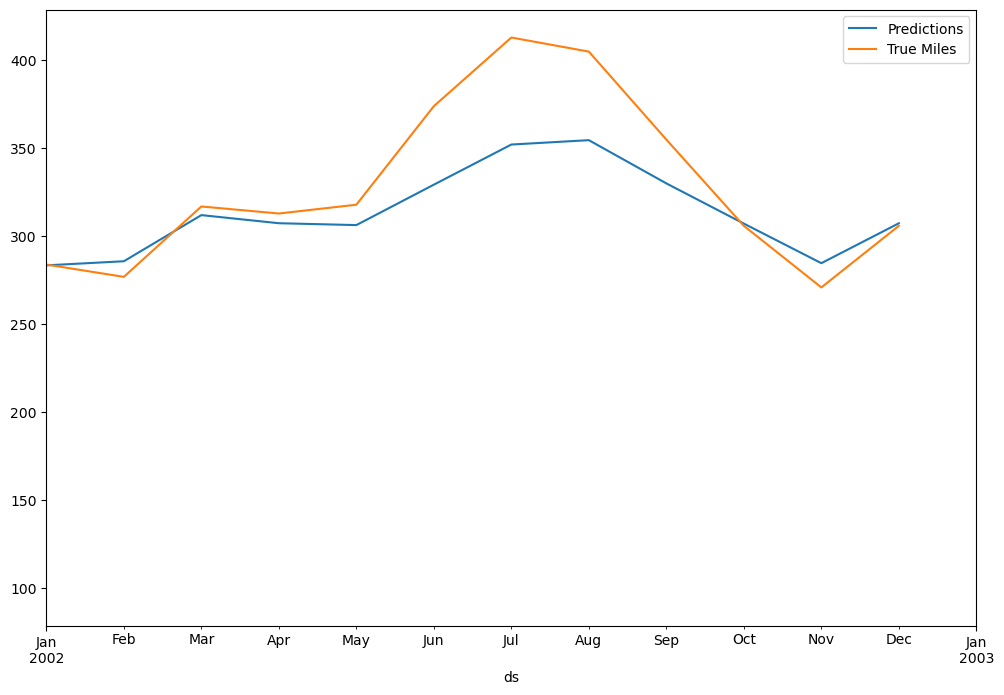

In [141]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

test.plot(x='ds',y='y',label='True Miles',legend=True,ax=ax,xlim=('2002-01-01','2003-01-01'))

In [110]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [111]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
108,2004-01-01,367.900087,352.745402,384.660177
109,2004-02-01,366.869921,351.128453,383.934008
110,2004-03-01,399.394185,383.098704,416.323903
111,2004-04-01,392.922925,377.351151,410.401506
112,2004-05-01,396.303869,380.079288,413.257501
113,2004-06-01,427.256288,411.568588,443.399704
114,2004-07-01,460.658505,444.035756,477.802469
115,2004-08-01,452.741522,436.053033,469.059664
116,2004-09-01,426.681177,410.288286,443.224302
117,2004-10-01,396.056105,378.932778,412.479110


### Plotting Forecast

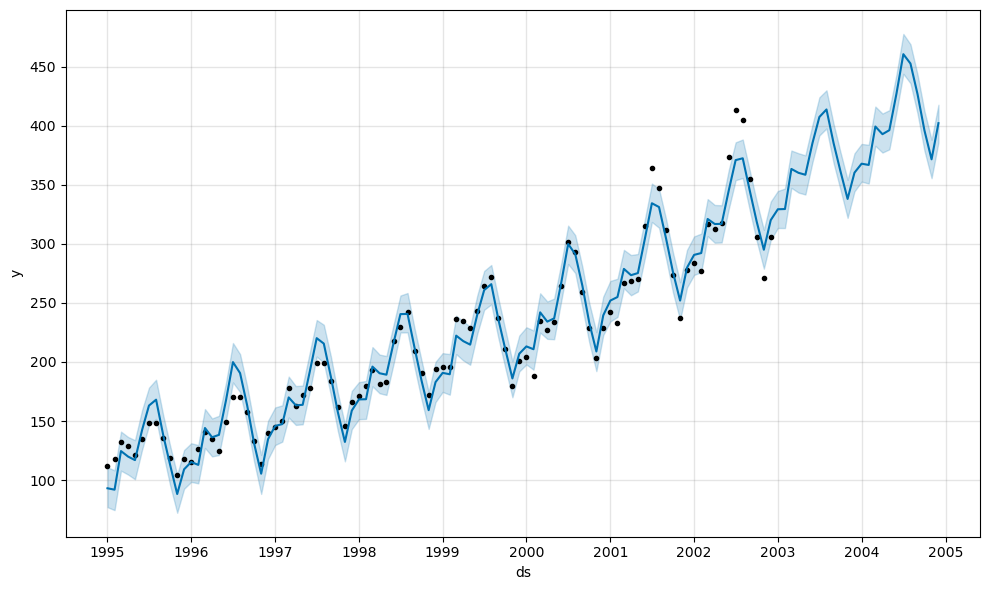

In [112]:
m.plot(forecast);

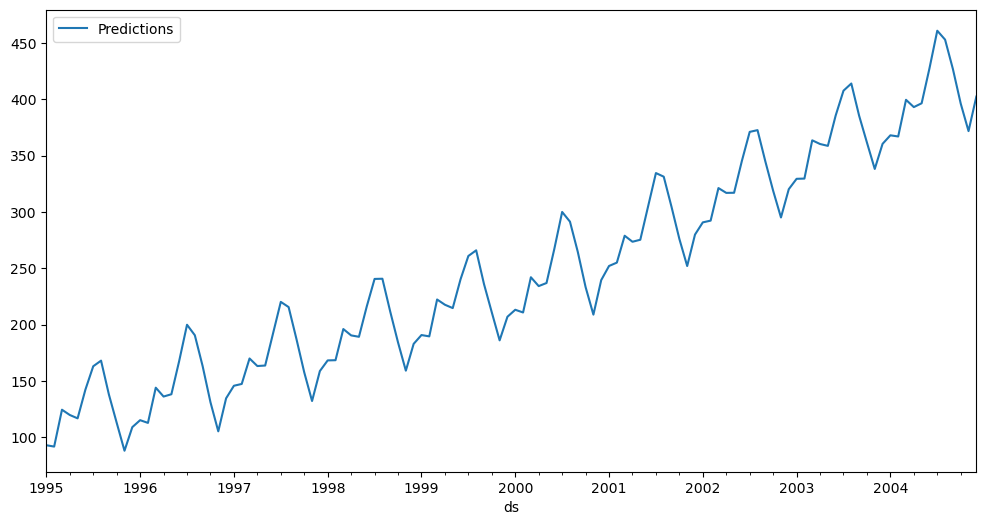

In [118]:
ax = forecast.plot(x='ds', y='yhat', label = 'Predictions', figsize=(12,6))

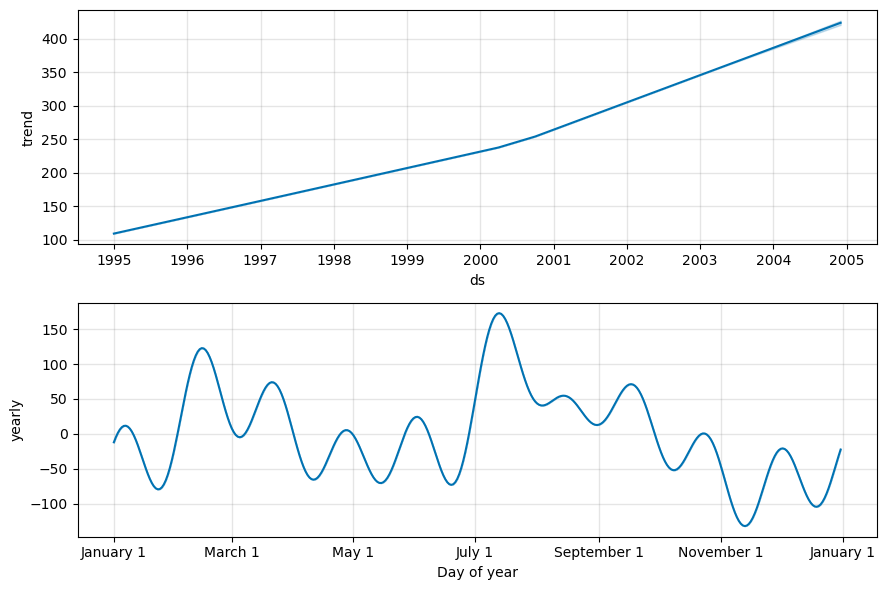

In [119]:
m.plot_components(forecast);

### Model Evaluation

In [142]:
from statsmodels.tools.eval_measures import rmse

In [143]:
predictions = forecast.iloc[-12:]['yhat']

In [144]:
predictions

84    283.545241
85    285.872197
86    312.089735
87    307.479274
88    306.422684
89    329.392874
90    352.193891
91    354.675227
92    330.110906
93    307.267007
94    284.781789
95    307.448012
Name: yhat, dtype: float64

In [145]:
test['y']

84    284
85    277
86    317
87    313
88    318
89    374
90    413
91    405
92    355
93    306
94    271
95    306
Name: y, dtype: int64

In [146]:
rmse(predictions,test['y'])

27.839441681439755

In [147]:
test.mean()

ds    2002-06-16 12:00:00
y                  328.25
dtype: object

### Prophet Diagnostics

In [149]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [150]:
#INITIAL
initial = 5 * 365
initial = str(initial) + ' days'

In [151]:
initial

'1825 days'

In [152]:
#PERIOD
period = 5 * 365
period = str(period) + ' days'

In [153]:
period

'1825 days'

In [154]:
#HORIZON 
horizon = 365
horizon = str(horizon) + ' days'

In [155]:
horizon

'365 days'

In [156]:
df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)

  0%|          | 0/1 [00:00<?, ?it/s]

19:30:44 - cmdstanpy - INFO - Chain [1] start processing
19:30:44 - cmdstanpy - INFO - Chain [1] done processing


In [157]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2001-01-01,245.332577,234.964562,255.518259,242,2000-12-01
1,2001-02-01,256.044237,245.384658,267.484483,233,2000-12-01
2,2001-03-01,267.540764,257.008740,278.201929,267,2000-12-01
3,2001-04-01,259.752305,249.060618,269.880232,269,2000-12-01
4,2001-05-01,260.130877,248.940854,270.155143,270,2000-12-01


In [158]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
7,2001-08-01,304.266921,292.856167,314.817442,347,2000-12-01
8,2001-09-01,280.662290,269.828898,291.327149,312,2000-12-01
9,2001-10-01,256.024353,244.950809,266.642667,274,2000-12-01
10,2001-11-01,234.809558,224.156824,244.805476,237,2000-12-01
11,2001-12-01,257.509494,246.357521,268.542046,278,2000-12-01


In [159]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,11.106067,3.332577,3.332577,0.013771,0.013771,0.013677,1.0
1,62 days,531.036854,23.044237,23.044237,0.098902,0.098902,0.094242,0.0
2,90 days,0.292426,0.540764,0.540764,0.002025,0.002025,0.002023,1.0
3,121 days,85.519871,9.247695,9.247695,0.034378,0.034378,0.034979,1.0
4,151 days,97.399588,9.869123,9.869123,0.036552,0.036552,0.037233,1.0
5,182 days,1093.022839,33.060896,33.060896,0.104955,0.104955,0.110768,0.0
6,212 days,3506.751274,59.217829,59.217829,0.162686,0.162686,0.177092,0.0
7,243 days,1826.116038,42.733079,42.733079,0.123150,0.123150,0.131231,0.0
8,274 days,982.052062,31.337710,31.337710,0.100441,0.100441,0.105752,0.0
9,304 days,323.123874,17.975647,17.975647,0.065605,0.065605,0.067830,0.0


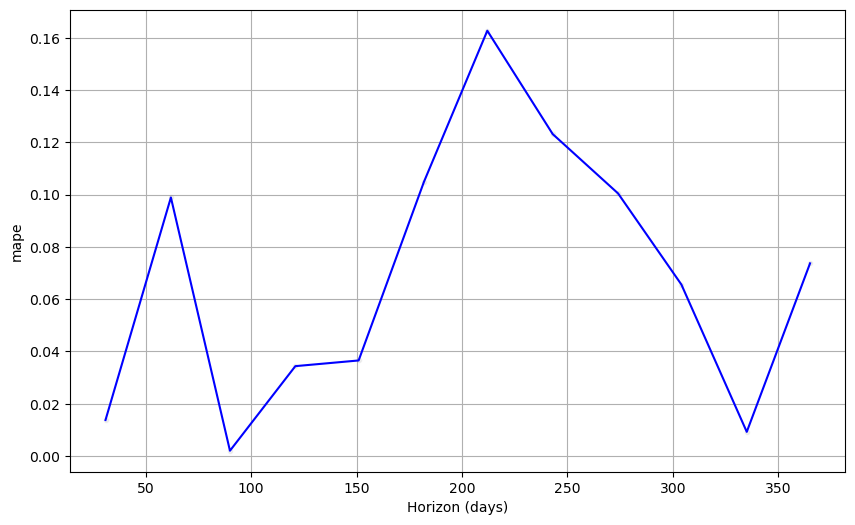

In [161]:
plot_cross_validation_metric(df_cv, metric='mape');

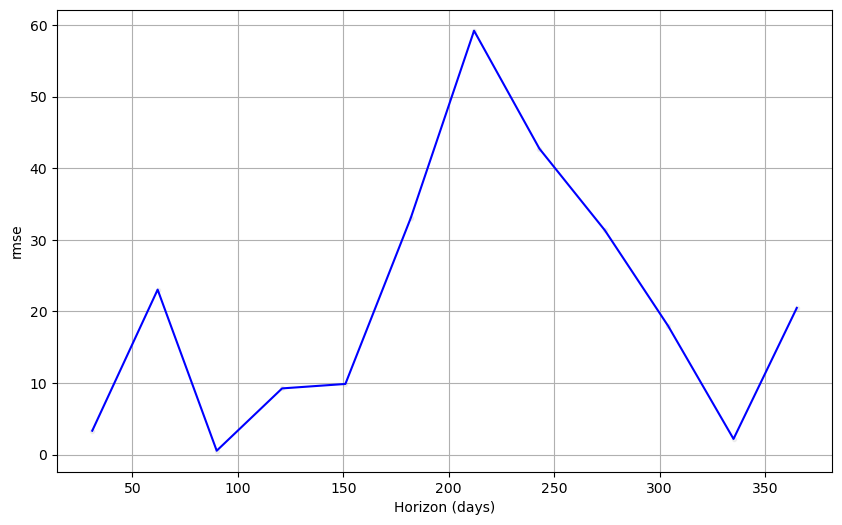

In [160]:
plot_cross_validation_metric(df_cv, metric='rmse');